# Numerai EDA

In [1]:
import os
os.chdir('D:/DataNomads/numerai/') #Set working directory
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import seaborn as sns
import matplotlib.ticker as ticker
import itertools
import datetime
from collections import Counter

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

sns.set_style('whitegrid')

%matplotlib inline

In [2]:
# Read Numerai training data
training_data = pd.read_csv("./data/raw/numerai_dataset_112/numerai_training_data.csv")
tournament_data = pd.read_csv("./data/raw/numerai_dataset_112/numerai_tournament_data.csv")
validation_data = tournament_data[tournament_data.data_type == "validation"]

## Data Description

Each new round comes with a **unique** data zip. Compare your predictions against the given validation targets to see how well your model is performing but be careful not to overfit.

### Data types

Four types of data:
    1. Training: includes targets for models to be trained on
    2. Validation: includes targets to allow for testing locally
    3. Tournament: Does not contain target variables but it is used internally by Numerai to        validate your model for training purposes
    4. Live: Primary way your model is evaluated on Numerai. Payouts are based on this data and no target variable is included
    
> **ERAS**: They represent an unspecified period of time.

**Task**: Binary Classification

### Scoring

**Metric**: LogLoss. The benchmark is <0.693
    1. Validation logloss: graded against validation targets and publically displayed
    2. Test logloss: only known to Numerai
    3. Live logloss: calculated at round resolution against live market data, which is used for payout calculation
    
**Consistency**: Percentage of *ERAS* in which your predictions beat the log loss benchmark on the test set. A submission is considered consistent if consistency >= 58%

Include consistent performance across all eras into the objective function of the model.

**Concordance**: All predictions ar to be produced by the same model.

[Submission criteria is included here.](https://github.com/numerai/submission-criteria)




In [3]:
print("Training data dimensions: ", training_data.shape)
print("Tournament data dimensions: ", tournament_data.shape)
print("Validation data dimensions: ", validation_data.shape)

Training data dimensions:  (393613, 58)
Tournament data dimensions:  (243288, 58)
Validation data dimensions:  (46362, 58)


In [4]:
print("\nData type in tournament data\n")

tournament_data_type = pd.crosstab(index=tournament_data["data_type"],columns="Frequency",
                                   margins=True, normalize="all")
tournament_data_type.columns = ["Data Type", "Total"]
tournament_data_type.index = ["Live", "Test", "Validation", "Total"]
tournament_data_type = tournament_data_type * 100
tournament_data_type.style


Data type in tournament data



,Data Type,Total
Live,1.77608,1.77608
Test,79.1675,79.1675
Validation,19.0564,19.0564
Total,100,100


In [5]:
training_data.head()

,id,era,data_type,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature46,feature47,feature48,feature49,feature50,target_bernie,target_charles,target_elizabeth,target_jordan,target_ken
0,n2b2e3dd163cb422,era1,train,0.43487,0.44645,0.25802,0.37149,0.62235,0.67451,0.68103,...,0.57426,0.57946,0.49646,0.48968,0.54194,1,1,1,1,1
1,n177021a571c94c8,era1,train,0.50038,0.39216,0.38394,0.51213,0.36660,0.46911,0.68204,...,0.67558,0.45577,0.80908,0.50287,0.61629,0,0,0,0,0
2,n7830fa4c0cd8466,era1,train,0.47416,0.34143,0.39528,0.46337,0.72953,0.45962,0.47869,...,0.36389,0.80602,0.39253,0.41821,0.58679,0,0,0,0,0
3,nc594a184cee941b,era1,train,0.48759,0.55903,0.43987,0.38834,0.44650,0.46389,0.70749,...,0.48793,0.62432,0.52898,0.49009,0.49557,0,0,0,0,0
4,nc5ab8667901946a,era1,train,0.23433,0.55499,0.47849,0.56990,0.64945,0.47152,0.62085,...,0.44587,0.47770,0.44020,0.47895,0.57978,0,0,0,1,0


In [6]:
training_data.dtypes

id                   object
era                  object
data_type            object
feature1            float64
feature2            float64
feature3            float64
feature4            float64
feature5            float64
feature6            float64
feature7            float64
feature8            float64
feature9            float64
feature10           float64
feature11           float64
feature12           float64
feature13           float64
feature14           float64
feature15           float64
feature16           float64
feature17           float64
feature18           float64
feature19           float64
feature20           float64
feature21           float64
feature22           float64
feature23           float64
feature24           float64
feature25           float64
feature26           float64
feature27           float64
feature28           float64
feature29           float64
feature30           float64
feature31           float64
feature32           float64
feature33           

In [7]:
target_cols = ["target_bernie", "target_charles", "target_elizabeth", "target_jordan", "target_ken"]
id_cols = ["id", "era", "data_type"]
training_data.data_type.value_counts()

train    393613
Name: data_type, dtype: int64

In [8]:
# Missing values in training data
na_perc = {}
for col in training_data.columns:
    na_perc[col] = training_data[col].isnull().sum()*100/len(training_data)
print ("Missing Values: ", any(na_perc.values()) > 0)

Missing Values:  False


Text(0.5,1,'Correlation heatmap for the features')

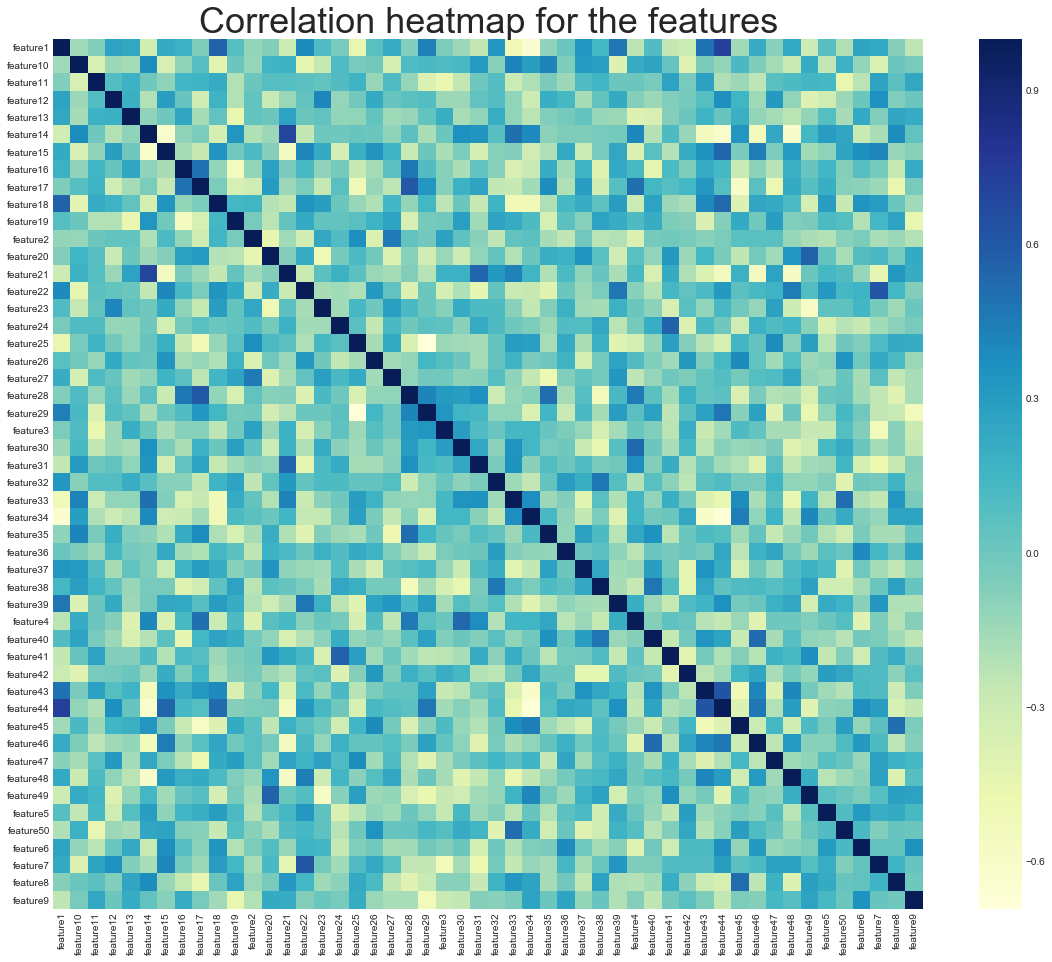

In [9]:
# Correlation 

corrmat = training_data[training_data.columns.difference(target_cols + id_cols)].corr()

f, ax = plt.subplots(figsize=(20, 16))

sns.heatmap(corrmat, square = True, cmap = 'YlGnBu')
plt.savefig("./reports/figures/Feature_Correlation_Matrix.png")
plt.title('Correlation heatmap for the features', fontsize=36)

In [10]:
def target_distribution_plots(train_df, target_cols, sup_title):
    # Class distribution
    ncount = len(train_df)
    plt.suptitle(sup_title, fontsize = 48)
    for i in range(len(target_cols)):
        plt.subplot(3,2,i+1)
        sns.set_context({"figure.figsize": (16, 14)})
        sns.set(font_scale = 1.5)
        g = sns.countplot(x = target_cols[1], data = train_df)
        #g.set_xticklabels(labels,rotation = 90)
        g.set_title("Class Distribution: {}".format(target_cols[i]), fontsize=24)
        g.set_xlabel(target_cols[i], fontsize=20)
        g.set_ylabel('Frequency [%]', fontsize=20, labelpad=25)
        g.axes.grid(0)

        g2 = g.twinx()
        g2.yaxis.tick_left()
        g.yaxis.tick_right()

        for p in g.patches:
            x=p.get_bbox().get_points()[:,0]
            y=p.get_bbox().get_points()[1,1]
            g.annotate('{:.2f}%'.format(100.*y/ncount), (x.mean(), y), 
                    ha='center', va='bottom') # set the alignment of the text

        g.yaxis.set_major_locator(ticker.LinearLocator(11))

        # Fix the frequency range to 0-100
        g2.set_ylim(0,100)
        g.set_ylim(0,ncount)

        # And use a MultipleLocator to ensure a tick spacing of 10
        g2.yaxis.set_major_locator(ticker.MultipleLocator(10))
        g2.set_ylabel('Count', fontsize=15, labelpad=60)
        g2.axes.grid(0)
        plt.tight_layout()
    plt.savefig("./reports/figures/Class_Distributions.png")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

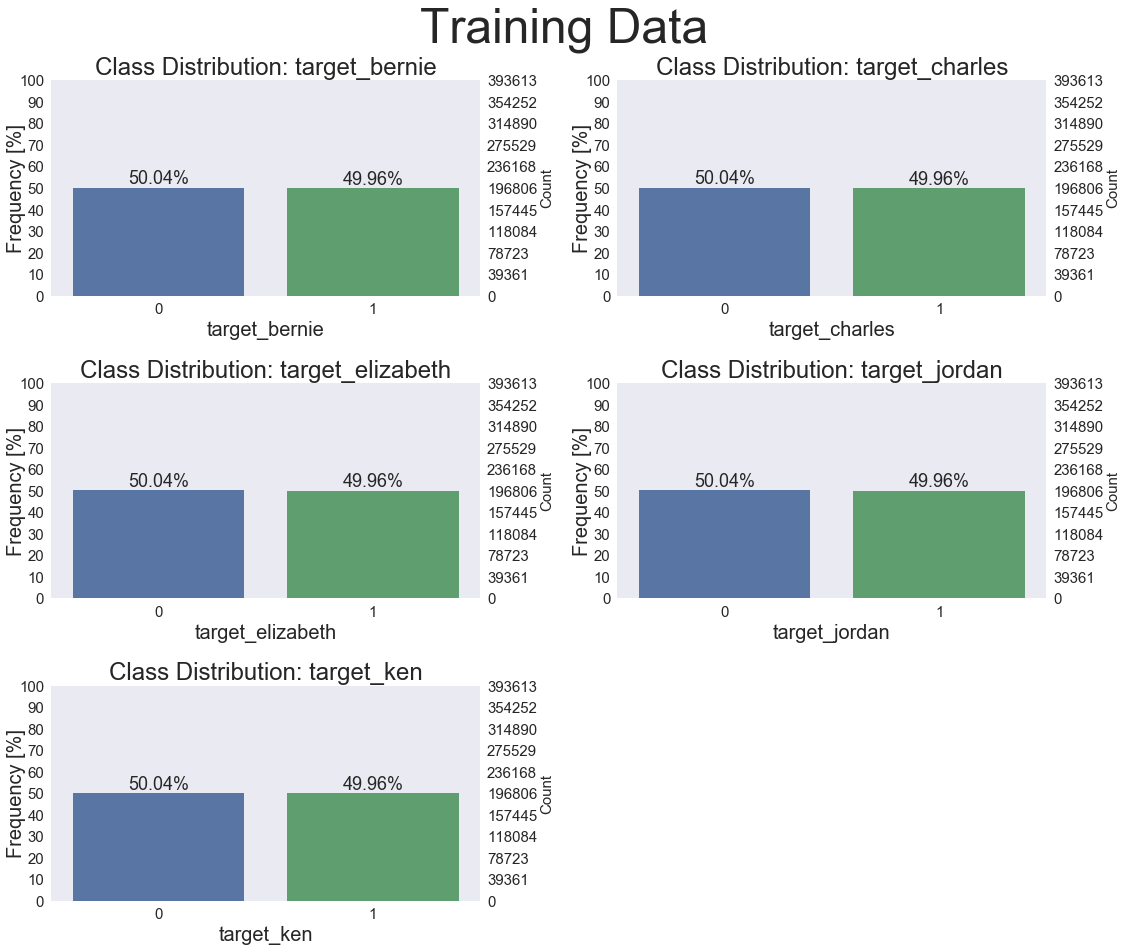

In [12]:
target_distribution_plots(training_data, target_cols, sup_title = "Training Data")

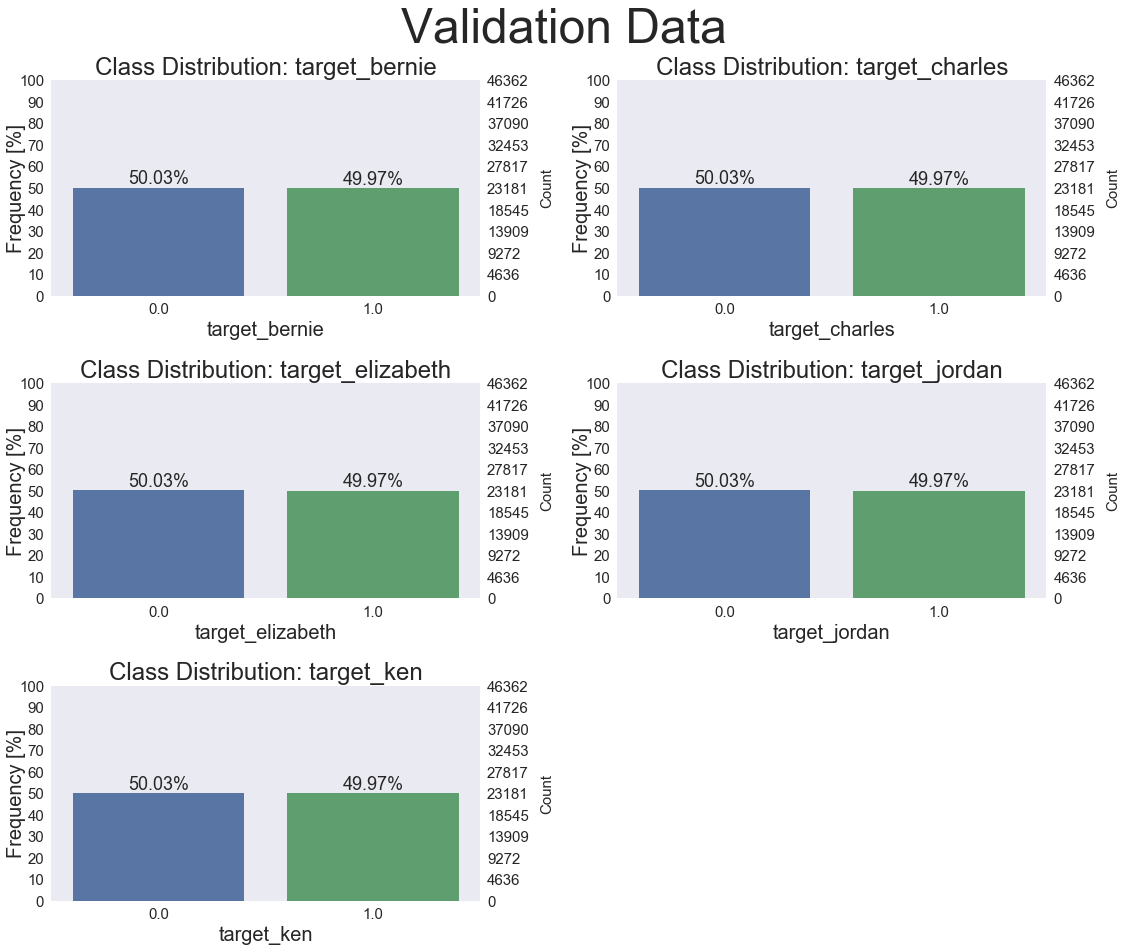

In [13]:
target_distribution_plots(validation_data, target_cols, sup_title = "Validation Data")

<Figure size 1152x1008 with 0 Axes>

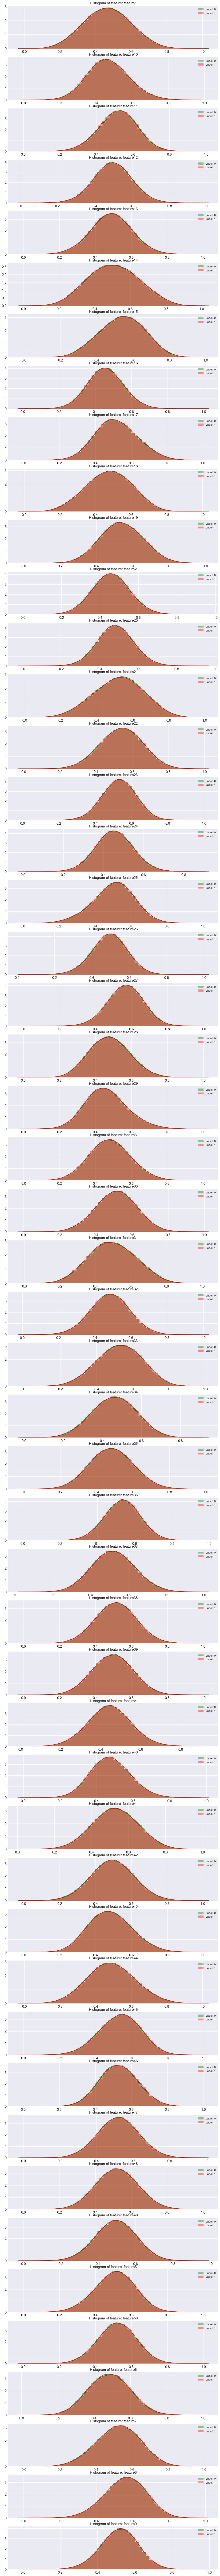

In [14]:
import itertools
# Reference - https://www.kaggle.com/currie32/d/dalpozz/creditcardfraud/predicting-fraud-with-tensorflow# Refere 
target_col_name = target_cols[1]
plt.clf()
features = training_data.columns.difference(target_cols + id_cols)
plt.figure(figsize=(16,len(features)*4))
gs = gridspec.GridSpec(len(features), 1)
for i, col_name in enumerate(training_data[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(training_data[col_name][training_data[target_col_name] == 0], bins=50, label = "Label: 0",color='green')
    sns.distplot(training_data[col_name][training_data[target_col_name] == 1], bins=50, label = "Label: 1", color='red')
    ax.set_xlabel('')
    ax.set_title('Histogram of feature: ' + str(col_name),fontsize=15)
    plt.legend(loc='best',fontsize=12)
plt.savefig("./reports/figures/Feature_Distributions.png")
plt.show()

In [15]:
training_data[training_data.columns.difference(target_cols + id_cols)].describe()

,feature1,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,...,feature46,feature47,feature48,feature49,feature5,feature50,feature6,feature7,feature8,feature9
count,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,...,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000,393613.000000
mean,0.467463,0.469235,0.518194,0.497087,0.489780,0.506731,0.540536,0.457506,0.518136,0.476602,...,0.530340,0.519575,0.520685,0.494798,0.509518,0.521452,0.484868,0.524472,0.558369,0.517500
std,0.132239,0.115823,0.107760,0.103159,0.116009,0.143601,0.123725,0.099805,0.118100,0.129001,...,0.107398,0.112527,0.116171,0.109163,0.113137,0.107282,0.115371,0.123702,0.114970,0.101921
min,0.000000,0.000000,0.000000,0.017450,0.000000,0.008190,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011710,0.000000,0.000000,0.000000
25%,0.374720,0.389630,0.447820,0.428440,0.412850,0.404060,0.454630,0.390050,0.436100,0.387310,...,0.456310,0.443610,0.441100,0.421230,0.434950,0.449850,0.404670,0.441280,0.482230,0.451020
50%,0.466740,0.465030,0.520750,0.496960,0.489920,0.504510,0.543410,0.456070,0.513180,0.478590,...,0.528500,0.519440,0.520260,0.495450,0.512560,0.522160,0.484370,0.527450,0.562140,0.519930
75%,0.558860,0.544910,0.591040,0.565580,0.567100,0.607820,0.628530,0.523590,0.596830,0.567920,...,0.602850,0.595220,0.599690,0.569210,0.587120,0.593980,0.563480,0.610540,0.638510,0.586380
max,1.000000,0.992050,0.985820,0.981010,1.000000,1.000000,0.983280,1.000000,1.000000,1.000000,...,1.000000,0.983350,1.000000,0.961840,1.000000,1.000000,1.000000,0.992800,0.986440,0.969310


# GBM

In [16]:
import h2o
import math

from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(nthreads=-1, strict_version_check=True)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.171-b11, mixed mode)
  Starting server from C:\Users\Owner\Anaconda3\envs\datanomads\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\Owner\AppData\Local\Temp\tmp2qvgzlvu
  JVM stdout: C:\Users\Owner\AppData\Local\Temp\tmp2qvgzlvu\h2o_Owner_started_from_python.out
  JVM stderr: C:\Users\Owner\AppData\Local\Temp\tmp2qvgzlvu\h2o_Owner_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,30 days
H2O cluster name:,H2O_from_python_Owner_jeecgr
H2O cluster total nodes:,1
H2O cluster free memory:,3.533 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


## Convert pandas DF to H2O DF

In [17]:
var_list = list(features)
target = "target_bernie"

var_list.append(target)
var_list.append("id")

nmr_train_df = training_data[var_list]
nmr_train_df.shape

(393613, 52)

In [18]:
nmr_train_hf = h2o.H2OFrame(nmr_train_df)
nmr_train_hf[target] = nmr_train_hf[target].asfactor()

C:\Users\Owner\Anaconda3\envs\datanomads\lib\site-packages\h2o\utils\shared_utils.py:170: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%


## Split the data

In [19]:
nmr_train, nmr_valid, nmr_test = nmr_train_hf.split_frame(ratios=[0.6,0.2],
                                                         seed=2018112,
                                                         destination_frames=['nmr_train.hex', 'nmr_valid.hex', 'nmr_test.hex'])
print("Training data: ", nmr_train.shape)
print("Validation data: ", nmr_valid.shape)
print("Test data: ", nmr_test.shape)

Training data:  (236188, 52)
Validation data:  (78606, 52)
Test data:  (78819, 52)


## Baseline Performance

In [20]:
gbm = H2OGradientBoostingEstimator()
gbm.train(x=list(features), y=target, training_frame=nmr_train)

print(gbm)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1529797220921_1


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.24731855185443516
RMSE: 0.4973113228697243
LogLoss: 0.6877589663850876
Mean Per-Class Error: 0.45300184567689494
AUC: 0.5701446324335124
Gini: 0.14028926486702487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44907094683634813: 


,0,1,Error,Rate
0,4249.0,113813.0,0.964,(113813.0/118062.0)
1,1399.0,116727.0,0.0118,(1399.0/118126.0)
Total,5648.0,230540.0,0.4878,(115212.0/236188.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.4490709,0.6695634,326.0
max f2,0.4211314,0.8339162,358.0
max f0point5,0.4802191,0.5667128,258.0
max accuracy,0.5017491,0.5470007,182.0
max precision,0.7050399,1.0,0.0
max recall,0.3724450,1.0,384.0
max specificity,0.7050399,1.0,0.0
max absolute_mcc,0.4867799,0.0969045,239.0
max min_per_class_accuracy,0.5022064,0.5452898,180.0
max mean_per_class_accuracy,0.5017491,0.5469982,182.0


Gains/Lift Table: Avg response rate: 50.01 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,cumulative_response_rate,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100005,0.5485580,1.5347238,1.5347238,0.7675699,0.7675699,0.0153480,0.0153480,53.4723847,53.4723847
,2,0.0200010,0.5417549,1.3103985,1.4225612,0.6553768,0.7114733,0.0131047,0.0284527,31.0398519,42.2561183
,3,0.0300015,0.5379339,1.2409846,1.3620357,0.6206605,0.6812024,0.0124105,0.0408631,24.0984644,36.2035670
,4,0.0400063,0.5352594,1.1820750,1.3170312,0.5911976,0.6586940,0.0118264,0.0526895,18.2074953,31.7031207
,5,0.0500025,0.5331512,1.1830763,1.2902516,0.5916984,0.6453006,0.0118264,0.0645159,18.3076287,29.0251565
,6,0.1000008,0.5262486,1.1670984,1.2286776,0.5837073,0.6145053,0.0583529,0.1228688,16.7098434,22.8677607
,7,0.1500034,0.5218686,1.0965699,1.1846405,0.5484335,0.5924807,0.0548313,0.1777001,9.6569924,18.4640470
,8,0.2000017,0.5183117,1.1014036,1.1638321,0.5508510,0.5820738,0.0550683,0.2327684,10.1403644,16.3832144
,9,0.3000025,0.5124309,1.0648709,1.1308450,0.5325797,0.5655757,0.1064880,0.3392564,6.4870857,13.0845048
,10,0.3999992,0.5071898,1.0538257,1.1115908,0.5270556,0.5559460,0.1053790,0.4446354,5.3825715,11.1590827



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_lift,training_classification_error
,2018-06-23 18:41:01,0.034 sec,0.0,0.5000000,0.6931471,0.5,1.0,0.4998645
,2018-06-23 18:41:02,0.896 sec,1.0,0.4998705,0.6928882,0.5259626,1.0895557,0.4997544
,2018-06-23 18:41:03,1.445 sec,2.0,0.4997539,0.6926550,0.5314927,1.1130985,0.4995173
,2018-06-23 18:41:03,1.827 sec,3.0,0.4996505,0.6924481,0.5326653,1.2162044,0.4990135
,2018-06-23 18:41:04,2.254 sec,4.0,0.4995581,0.6922634,0.5342936,1.2335006,0.4989415
,2018-06-23 18:41:04,2.528 sec,5.0,0.4994596,0.6920663,0.5377032,1.2724585,0.4990135
,2018-06-23 18:41:04,2.785 sec,6.0,0.4993663,0.6918797,0.5400443,1.2289012,0.4987510
,2018-06-23 18:41:04,3.059 sec,7.0,0.4992809,0.6917089,0.5418490,1.2310822,0.4983149
,2018-06-23 18:41:05,3.328 sec,8.0,0.4992045,0.6915560,0.5431882,1.2546376,0.4974554
,2018-06-23 18:41:05,3.617 sec,9.0,0.4991286,0.6914042,0.5442416,1.2862393,0.4963758


Variable Importances: 


variable,relative_importance,scaled_importance,percentage
feature31,201.3665161,1.0,0.0602743
feature28,138.3311920,0.6869622,0.0414062
feature36,132.6313477,0.6586564,0.0397001
feature46,121.9114151,0.6054205,0.0364913
feature6,109.5851212,0.5442073,0.0328017
---,---,---,---
feature43,31.5077190,0.1564695,0.0094311
feature24,29.8880119,0.1484259,0.0089463
feature44,29.2017059,0.1450177,0.0087408
feature26,25.7780800,0.1280157,0.0077161



See the whole table with table.as_data_frame()



In [21]:
perf_valid = gbm.model_performance(nmr_valid)
print("AUC: ", perf_valid.auc())
print("LogLoss: ",perf_valid.logloss())

AUC:  0.5169094621674489
LogLoss:  0.6928922262261132


In [22]:
gbm.summary()

Model Summary: 


,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
,50.0,50.0,19123.0,5.0,5.0,5.0,15.0,32.0,25.46


In [23]:
cv_gbm = H2OGradientBoostingEstimator(nfolds = 4, seed = 0xDECAF)
cv_gbm.train(x = list(features), y = target, training_frame = nmr_train.rbind(nmr_valid))

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [24]:
cv_summary = cv_gbm.cross_validation_metrics_summary().as_data_frame()
perf_cv = cv_gbm.model_performance(xval=True)
print(perf_cv.logloss())

0.6925263871173855


In [25]:
print(cv_summary)

                                     mean             sd    cv_1_valid  \
0                  accuracy    0.49922496    6.846923E-4    0.49929476   
1                       auc    0.52131027    0.001200685    0.52044344   
2                       err    0.50077504    6.846923E-4    0.50070524   
3                 err_count      39410.25      57.905903       39404.0   
4                  f0point5     0.5547733   6.7568664E-4     0.5548526   
5                        f1    0.66595984    6.059535E-4     0.6660338   
6                        f2     0.8328857    3.729587E-4     0.8329376   
7            lift_top_group     1.0700084    0.011949456     1.0917836   
8                   logloss    0.69252634  1.04102364E-4     0.6926021   
9       max_per_class_error     0.9999238   2.5473872E-5     0.9999746   
10                      mcc   0.004980997    8.386907E-4  0.0035595908   
11  mean_per_class_accuracy     0.5000317    7.775347E-6     0.5000127   
12     mean_per_class_error    0.49996

In [26]:
gbm_lucky = H2OGradientBoostingEstimator(
  ## more trees is better if the learning rate is small enough 
  ## here, use "more than enough" trees - we have early stopping
  ntrees = 10000,                                                            

  ## smaller learning rate is better (this is a good value for most datasets, but see below for annealing)
  learn_rate = 0.01,                                                         

  ## early stopping once the validation AUC doesn't improve by at least 0.01% for 5 consecutive scoring events
  stopping_rounds = 5, stopping_tolerance = 1e-4, stopping_metric = "AUC", 

  ## sample 80% of rows per tree
  sample_rate = 0.8,                                                       

  ## sample 80% of columns per split
  col_sample_rate = 0.8,                                                   

  ## fix a random number generator seed for reproducibility
  seed = 1234,                                                             

  ## score every 10 trees to make early stopping reproducible (it depends on the scoring interval)
  score_tree_interval = 10)

gbm_lucky.train(x=list(features), y=target, training_frame=nmr_train, validation_frame=nmr_valid)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


In [27]:
perf_lucky = gbm_lucky.model_performance(nmr_valid)
print (perf_lucky.logloss())

0.6926509908127487
